In [90]:
# Importe as bibliotecas necessárias: pandas, numpy, torch, torchvision, etc.
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset, random_split

In [91]:
# Faça a importação do conjunto de dados a partir do dataset fornecido.
df = pd.read_csv('Best Songs on Spotify from 2000-2023.csv', delimiter=';')
dft = pd.read_csv('Best Songs on Spotify from 2000-2023.csv', delimiter=';')


In [92]:
df.columns

Index(['title', 'artist', 'top genre', 'year', 'bpm', 'energy',
       'danceability ', 'dB', 'liveness', 'valence', 'duration',
       'acousticness', 'speechiness ', 'popularity'],
      dtype='object')

In [93]:
# Printando algumas informações sobre o dataset
print(f'Shape do dataset: {df.shape}')
print('\n')
print(f'Número de valores NaNs: \n{df.isna().sum()}')

Shape do dataset: (2385, 14)


Número de valores NaNs: 
title            0
artist           0
top genre        0
year             0
bpm              0
energy           0
danceability     0
dB               0
liveness         0
valence          0
duration         0
acousticness     0
speechiness      0
popularity       0
dtype: int64


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          2385 non-null   object
 1   artist         2385 non-null   object
 2   top genre      2385 non-null   object
 3   year           2385 non-null   int64 
 4   bpm            2385 non-null   int64 
 5   energy         2385 non-null   int64 
 6   danceability   2385 non-null   int64 
 7   dB             2385 non-null   int64 
 8   liveness       2385 non-null   int64 
 9   valence        2385 non-null   int64 
 10  duration       2385 non-null   int64 
 11  acousticness   2385 non-null   int64 
 12  speechiness    2385 non-null   int64 
 13  popularity     2385 non-null   int64 
dtypes: int64(11), object(3)
memory usage: 261.0+ KB


In [95]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Gerando um conjunto de dados de exemplo
X, y = make_classification(n_samples=300, n_features=13, random_state=0)

# Criando um estimador/modelo
estimator = LogisticRegression()

# Criando o seletor de features RFE
rfe = RFE(estimator, n_features_to_select=8)

# Realizando a seleção de features
X_selected = rfe.fit_transform(X, y)

# Obtendo as features selecionadas
selected_features = rfe.support_
feature_ranking = rfe.ranking_

print("Features selecionadas:")
for feature, selected in enumerate(selected_features):
    if selected:
        print(f"Feature {feature+1}")

print("\nRanking das features:")
for feature, rank in enumerate(feature_ranking):
    print(f"Feature {feature+1}: {rank}")

Features selecionadas:
Feature 1
Feature 2
Feature 3
Feature 8
Feature 9
Feature 10
Feature 11
Feature 13

Ranking das features:
Feature 1: 1
Feature 2: 1
Feature 3: 1
Feature 4: 5
Feature 5: 3
Feature 6: 6
Feature 7: 2
Feature 8: 1
Feature 9: 1
Feature 10: 1
Feature 11: 1
Feature 12: 4
Feature 13: 1


In [96]:
# Realize o pré-processamento necessário no conjunto de dados, incluindo a 
# categorização dos valores da coluna "popularity" 
# em três classes (0, 1 e 2) usando a função pd.cut.
dft["popularity"]=pd.cut(dft["popularity"],
                              bins = [0,50,75,100],
                              labels = [0,1,2],include_lowest=True)
print('Porcentagem correspondente a cada label (2= mais popular e 0 = menos popular)')
dft["popularity"].value_counts(dropna=False,normalize=True)*100

Porcentagem correspondente a cada label (2= mais popular e 0 = menos popular)


1    58.448637
2    36.477987
0     5.073375
Name: popularity, dtype: float64

In [97]:
# Realize a codificação one-hot das colunas "artist" e "top genre" usando a função onehot_encode.
def onehot_encode(df, column, prefix):
  data = df.copy()
  dummies = pd.get_dummies(data[column], prefix=prefix)
  data = pd.concat([data, dummies], axis=1)
  data = data.drop(column, axis=1)
  return data

df = onehot_encode(df, 'artist', 'a')
df = onehot_encode(df, 'top genre', 'g')

In [98]:
# Converta os dados para tensores do PyTorch.
df=df.drop(['title', 'popularity'], axis=1)
dft=dft.drop(['title','artist','top genre','bpm','energy', 'dB','liveness','valence', 'acousticness'] ,axis=1)
dft=dft.drop(['danceability ','duration','speechiness ', 'year'], axis=1)

# Features target, e selecionadas
dft.to_csv('target_csv.csv', sep=',', index=False, encoding='utf-8', errors="ignore")
df.to_csv("new_csv.csv", sep=',', index=False, encoding='utf-8', errors="ignore")

song_numpy = np.loadtxt('new_csv.csv', dtype= np.float32, delimiter=",", skiprows=1)
target_numpy = np.loadtxt('target_csv.csv', dtype= np.float32, delimiter=",", skiprows=1)

songs_py = torch.from_numpy(song_numpy)
target_py = torch.from_numpy(target_numpy)

# Crie uma classe CTDataset que herda torch.utils.data.Dataset e implemente 
## os métodos init, len e getitem para representar o conjunto de dados.

class CTDataset(Dataset):
  def __init__(self, songs, popularity):
    self.x = songs
    self.y = popularity
  def __len__(self):
    return self.x.shape[0]
  def __getitem__(self, ix):
    return self.x[ix], self.y[ix]

Dataset = CTDataset(songs_py, target_py)
len(Dataset)

2385

In [99]:
## feature selecionada como target
dft.head()

,popularity
0,2
1,2
2,2
3,2
4,2


In [100]:
## features selecionadas para o algoritmo
df.head()

,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,...,g_uk alternative pop,g_uk contemporary r&b,g_uk dance,g_uk garage,g_uk hip hop,g_uk pop,g_viral pop,g_viral rap,g_viral trap,g_vocal house
0,2023,118,68,71,-4,3,65,200,6,7,...,0,0,0,0,0,0,0,0,0,0
1,2023,120,59,78,-8,35,73,174,44,3,...,0,0,0,0,0,0,0,0,0,0
2,2023,95,64,77,-7,17,53,195,74,14,...,0,0,0,0,0,0,0,0,0,0
3,2023,133,81,70,-8,25,86,131,25,5,...,0,0,0,0,0,0,0,0,0,0
4,2022,98,62,72,-6,8,17,222,42,5,...,0,0,0,0,0,0,0,0,0,0


In [101]:
## Divida o conjunto de dados em conjuntos de treinamento, validação e teste 
## usando a função random_split do PyTorch, de acordo com as proporções 
## especificadas.

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

num_samples = len(Dataset)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Usando random_split 
train_dataset, val_dataset, test_dataset = random_split(Dataset, [train_size, val_size, test_size])

# Crie carregadores de dados (DataLoader) para cada conjunto, com um 
## tamanho de lote (batch size) adequado.
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader)
len(val_loader)
len(test_loader)

8

In [102]:
# Defina a arquitetura da rede neural no PyTorch, incluindo as 
# camadas Linear necessárias.

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(1290, 640)
        self.fc2 = nn.Linear(640, 320)
        self.fc3 = nn.Linear(320, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = NeuralNet()

# Defina a função de perda (loss function) como CrossEntropyLoss e o otimizador como Adam
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [103]:

# class Classifier(nn.Module):

#       def __init__(self):

#           super().__init__()
#           self.fc1 = nn.Linear(784,256)
#           self.fc2 = nn.Linear(256,128)
#           self.fc3 = nn.Linear(128,64)
#           self.fc4 = nn.Linear(64,10)
#           self.dropout = nn.Dropout(0.2)

#       def forward(self,x):

#           x = x.view(x.shape[0],-1)
#           x = self.dropout(F.relu(self.fc1(x))) 
#           x = self.dropout(F.relu(self.fc2(x)))   
#           x = self.dropout(F.relu(self.fc3(x)))  
#           x = F.log_softmax(self.fc4(x))   

#           return x

In [104]:
# Mova o modelo para a GPU, se disponível, para acelerar o treinamento.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Execute o treinamento do modelo por um número específico de épocas, 
# calculando a perda média ao longo das iterações de treinamento.
num_epochs = 40
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    val_loss = 0.0
    for features, popularity in train_loader:
        features = features.to(device)
        popularity = (popularity.to(device)).long()
        
        optimizer.zero_grad()
        
        outputs = model(features)
        loss = criterion(outputs, popularity)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        val_loss += loss.item() 

        loss= running_loss/len(train_loader)
        val_loss= val_loss/len(val_loader)
        
        train_losses.append(loss)
        val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1},     Perda no Treinamento: {loss:.4f},     Perda na validação: {val_loss:.4f}")

Epoch 1,     Perda no Treinamento: 14.1893,     Perda na validação: 2.2743
Epoch 2,     Perda no Treinamento: 2.0054,     Perda na validação: 0.6522
Epoch 3,     Perda no Treinamento: 1.0415,     Perda na validação: 0.2625
Epoch 4,     Perda no Treinamento: 0.8540,     Perda na validação: 0.1809
Epoch 5,     Perda no Treinamento: 1.0488,     Perda na validação: 0.3349
Epoch 6,     Perda no Treinamento: 0.8612,     Perda na validação: 0.2923
Epoch 7,     Perda no Treinamento: 0.8220,     Perda na validação: 0.1965
Epoch 8,     Perda no Treinamento: 0.9746,     Perda na validação: 0.3155
Epoch 9,     Perda no Treinamento: 0.8286,     Perda na validação: 0.1349
Epoch 10,     Perda no Treinamento: 0.8672,     Perda na validação: 0.4828
Epoch 11,     Perda no Treinamento: 0.8667,     Perda na validação: 0.4407
Epoch 12,     Perda no Treinamento: 0.9494,     Perda na validação: 0.4070
Epoch 13,     Perda no Treinamento: 0.9986,     Perda na validação: 0.2107
Epoch 14,     Perda no Treinament

In [105]:
# Avalie o desempenho do modelo nos conjuntos de validação e teste, calculando a 
# acurácia, precisão, recall e exibindo o relatório de classificação.

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for features, popularity in val_loader:
        features = features.to(device)
        popularity = popularity.to(device)
        
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1) 
        total += popularity.size(0)
        correct += (predicted == popularity).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

# **Test (Hold-Out)

model.eval()

correct = 0
total = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for features, popularity in test_loader:
        features = features.to(device)
        popularity = popularity.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())  
        true_labels.extend(popularity.cpu().numpy())  

        total += popularity.size(0)
        correct += (predicted == popularity).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Calculando precision and recall
precision = 100*precision_score(true_labels, predicted_labels, average='weighted')
recall = 100*recall_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")

# Generando classification_report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Validation Accuracy: 44.54%
Test Accuracy: 37.45%
Precision: 50.52%
Recall: 37.45%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        31
         1.0       0.65      0.08      0.15       284
         2.0       0.35      0.95      0.51       163

    accuracy                           0.37       478
   macro avg       0.33      0.35      0.22       478
weighted avg       0.51      0.37      0.26       478



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

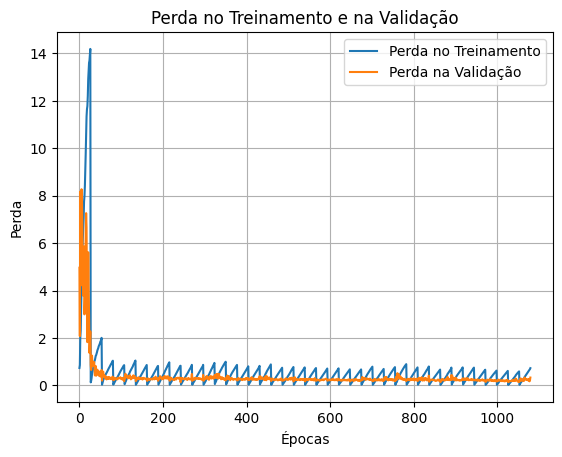

In [106]:

plt.plot(train_losses)
plt.plot(val_losses)
plt.grid()
plt.title("Perda no Treinamento e na Validação")
plt.legend(["Perda no Treinamento","Perda na Validação"])
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.show()
